# Trajectory Optimisation

In [1]:
import numpy as np
import torch
from torchdyn.models import NeuralODE

import matplotlib.pyplot as plt
import sys
import time
sys.path.append("../../../")

### Set Seed Here

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

### Define the Dynamic
- Then we can replace this with a NN

In [3]:
from nn import MLP

In [4]:
class Pendulum(torch.nn.Module):
    def __init__(self):
        super(Pendulum, self).__init__()
        self.g = 10.
        self.m = 1.
        self.l = 1.

        # self._policy = MLP([3, 16, 16, 1], activation='softplus')
        self._policy = MLP([3, 16, 16, 1], activation='tanh')
    
    def forward(self, x):
        th = x[:, 0]
        dth = x[:, 1]
        cth = torch.cos(th)
        sth = torch.sin(th)
        full_state = torch.stack([cth, sth, dth], dim=1)
        action = self.policy(full_state)[:, 0]

        dth = x[:, 1]
        ddth = (-3 * self.g / (2 * self.l) * torch.sin(th) + 3. / (self.m * self.l ** 2) * action)
        return torch.stack([dth, ddth], dim=1)
    
    def policy(self, x):
        action = self._policy(x)
        # action = torch.tanh(action) * 2
        # action = torch.cos(action) * 2
        # action = torch.clamp(action, min=-2, max=2)
        return action

In [5]:
pendulum = Pendulum()
pendulumODE = NeuralODE(pendulum, sensitivity='adjoint', solver='rk4').to(device)

### Check the Model

In [6]:
init_state = torch.tensor([3 * np.pi / 4, 0]).reshape(1, -1).float()
t_span = torch.linspace(0, 5, 100)
traj = pendulumODE.trajectory(init_state, t_span)
dummy = torch.stack([torch.cos(traj[:, 0, 0]), torch.sin(traj[:, 0, 0]), traj[:, 0, 1]], dim=1)
actions = pendulumODE.defunc.m.policy(dummy)
print(traj.shape)
print(actions.shape)

torch.Size([100, 1, 2])
torch.Size([100, 1])


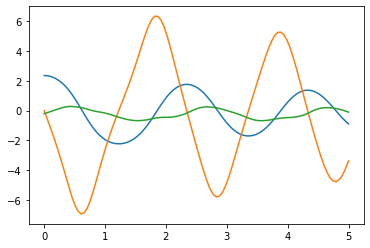

In [7]:
plt.plot(t_span.detach().numpy(), traj[:, 0, 0:2].detach().numpy())
plt.plot(t_span.detach().numpy(), actions.detach().numpy())
# plt.ylim(-2, 2)

### Optimise the control

In [8]:
import torch.optim as optim

In [9]:
# optimizer = optim.LBFGS(pendulum.parameters(), lr=0.05)
optimizer = optim.Adam(pendulum.parameters(), lr=0.05)

In [10]:
def total_cost(traj, actions):
    theta = traj[:, :, 0]
    theta_dt = traj[:, :, 1]
    actions = actions[:, :, 0]

    costs = angle_normalize(theta + np.pi) ** 2 + 0.1 * theta_dt ** 2 + 0.001 * actions ** 2
#     costs = torch.zeros_like(theta)
#     costs += 10 * (torch.cos(theta + np.pi) - 1) ** 2
#     costs += 0.1 * theta_dt ** 2
#     costs += 0.001 * actions ** 2

    # costs = angle_normalize(theta + np.pi) ** 2 + 0.1 * theta_dt ** 2
    costs += 0.01 * max(actions ** 2)
    
    # costs = (1 - torch.exp(-costs / (2 * 16)))
    return costs.sum()

def angle_normalize(x):
    return (((x + np.pi) % (2 * np.pi)) - np.pi)

0 tensor(2801.8123, grad_fn=<SumBackward0>)


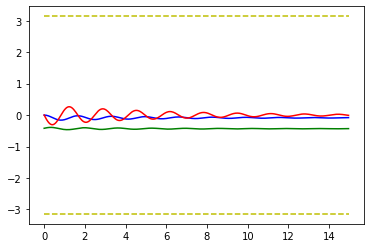

1 tensor(2321.0879, grad_fn=<SumBackward0>)


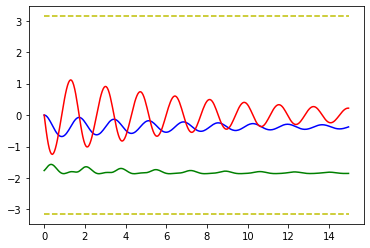

2 tensor(1884.1263, grad_fn=<SumBackward0>)


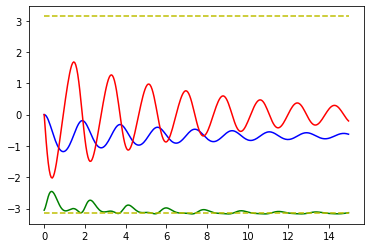

3 tensor(1407.9873, grad_fn=<SumBackward0>)


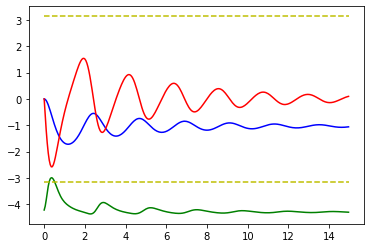

4 tensor(1356.5818, grad_fn=<SumBackward0>)


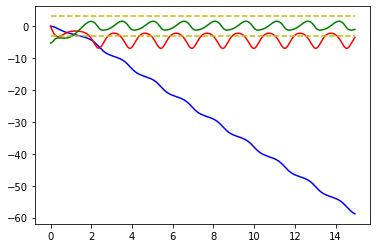

5 tensor(1406.9740, grad_fn=<SumBackward0>)


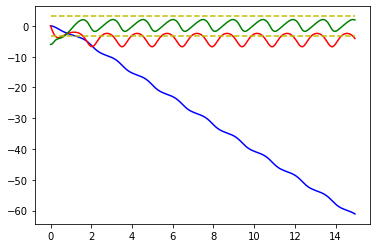

6 tensor(991.4248, grad_fn=<SumBackward0>)


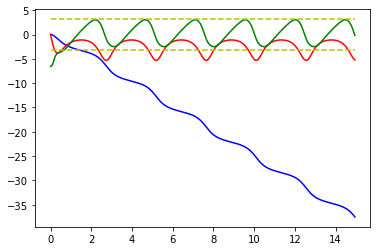

7 tensor(607.7714, grad_fn=<SumBackward0>)


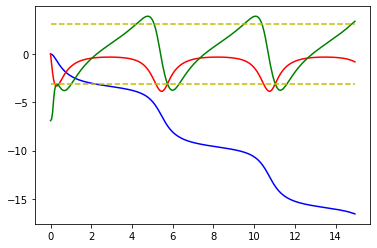

8 tensor(283.3246, grad_fn=<SumBackward0>)


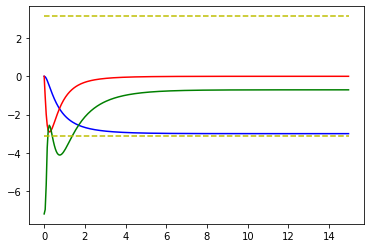

9 tensor(347.1583, grad_fn=<SumBackward0>)


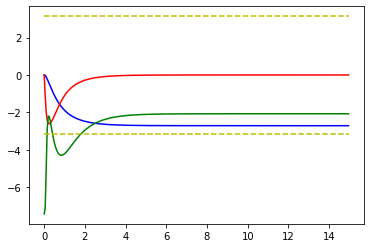

10 tensor(399.6937, grad_fn=<SumBackward0>)


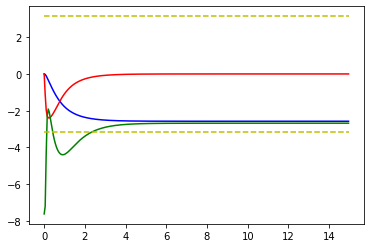

11 tensor(434.7134, grad_fn=<SumBackward0>)


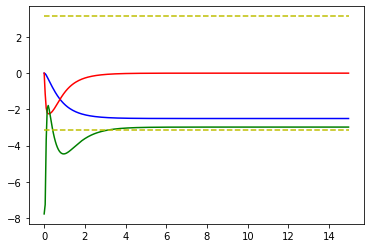

12 tensor(454.1599, grad_fn=<SumBackward0>)


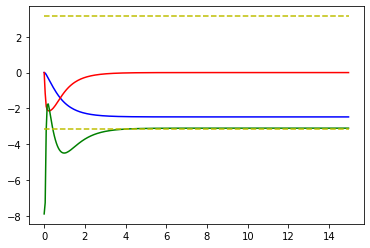

13 tensor(461.3990, grad_fn=<SumBackward0>)


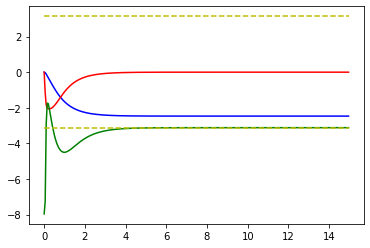

14 tensor(459.6708, grad_fn=<SumBackward0>)


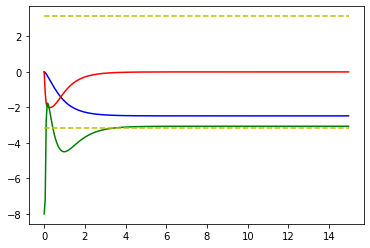

15 tensor(451.6943, grad_fn=<SumBackward0>)


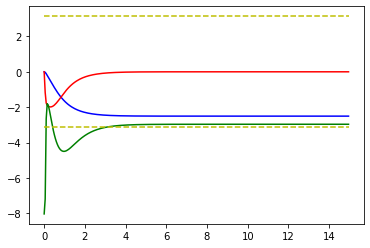

16 tensor(439.6142, grad_fn=<SumBackward0>)


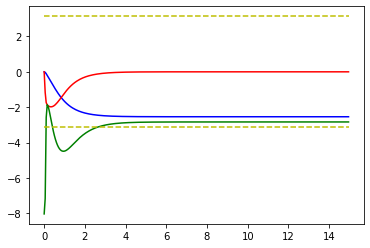

17 tensor(425.0428, grad_fn=<SumBackward0>)


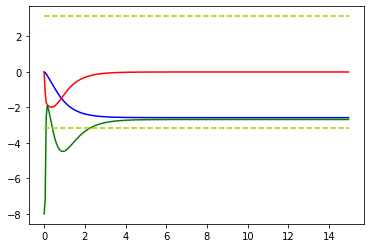

18 tensor(409.1398, grad_fn=<SumBackward0>)


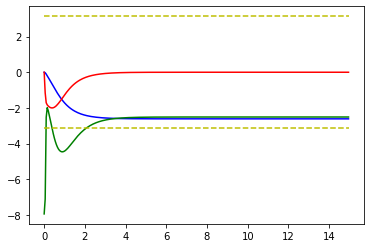

19 tensor(392.7007, grad_fn=<SumBackward0>)


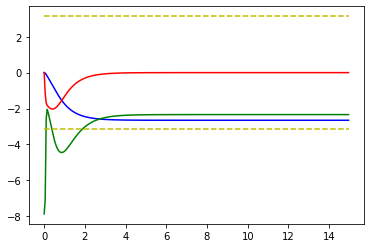

20 tensor(376.2457, grad_fn=<SumBackward0>)


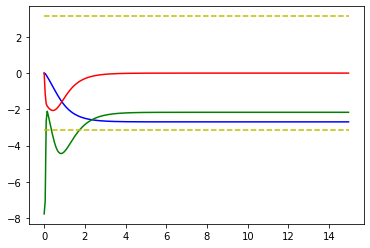

21 tensor(360.0955, grad_fn=<SumBackward0>)


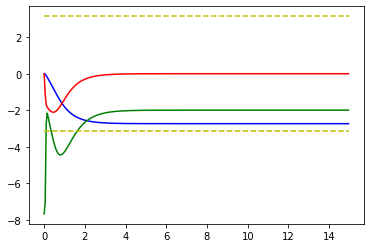

22 tensor(344.4349, grad_fn=<SumBackward0>)


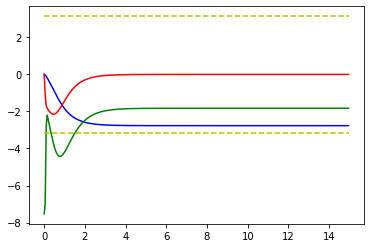

23 tensor(329.3588, grad_fn=<SumBackward0>)


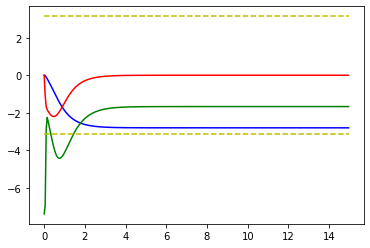

24 tensor(314.9074, grad_fn=<SumBackward0>)


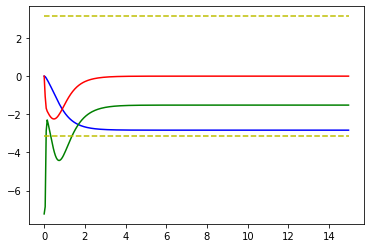

25 tensor(301.0918, grad_fn=<SumBackward0>)


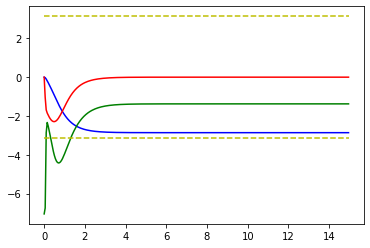

26 tensor(287.9110, grad_fn=<SumBackward0>)


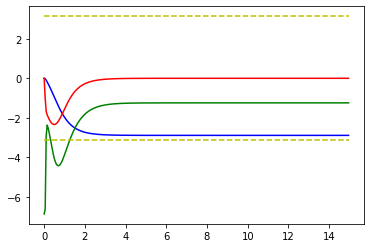

27 tensor(275.3617, grad_fn=<SumBackward0>)


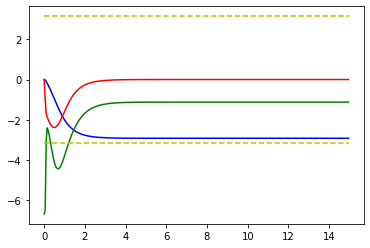

28 tensor(263.4420, grad_fn=<SumBackward0>)


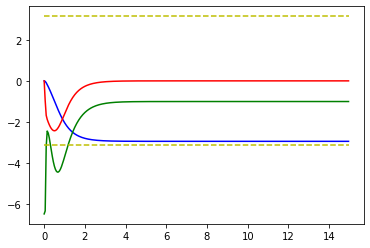

29 tensor(252.1521, grad_fn=<SumBackward0>)


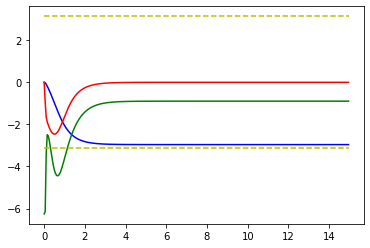

30 tensor(241.4954, grad_fn=<SumBackward0>)


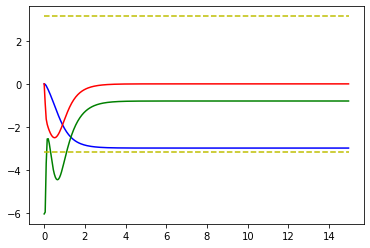

31 tensor(231.4771, grad_fn=<SumBackward0>)


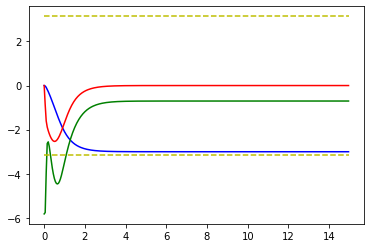

32 tensor(222.1038, grad_fn=<SumBackward0>)


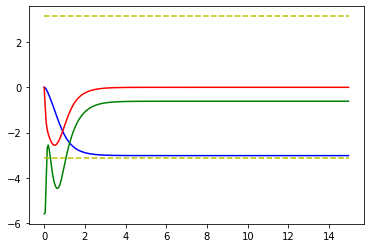

33 tensor(213.3867, grad_fn=<SumBackward0>)


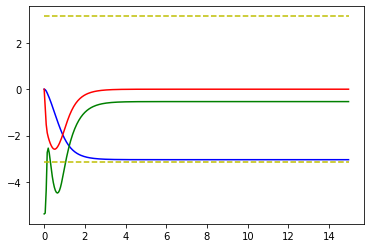

34 tensor(205.3506, grad_fn=<SumBackward0>)


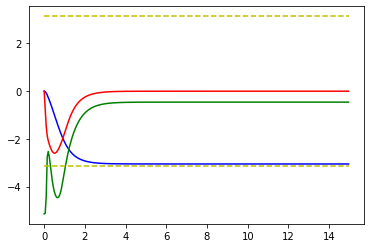

35 tensor(198.0449, grad_fn=<SumBackward0>)


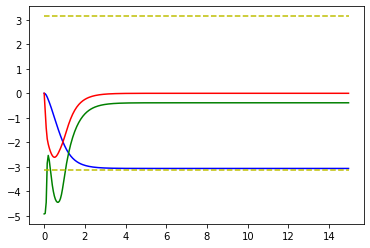

36 tensor(191.5530, grad_fn=<SumBackward0>)


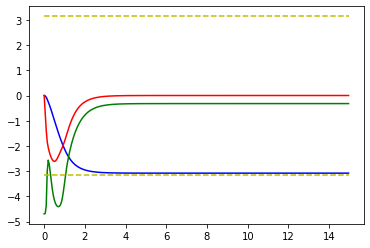

37 tensor(186.0240, grad_fn=<SumBackward0>)


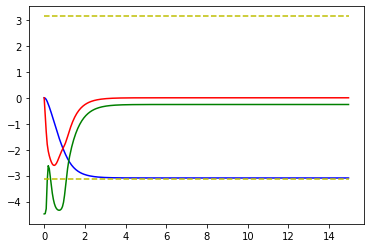

38 tensor(181.7762, grad_fn=<SumBackward0>)


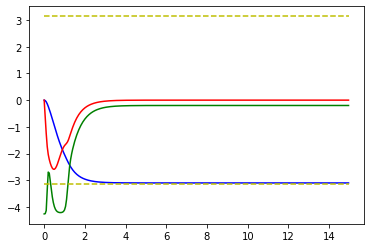

39 tensor(179.6480, grad_fn=<SumBackward0>)


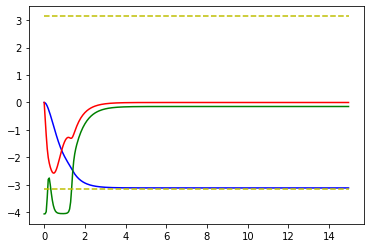

40 tensor(184.7803, grad_fn=<SumBackward0>)


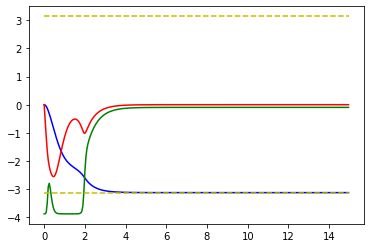

41 tensor(183.9350, grad_fn=<SumBackward0>)


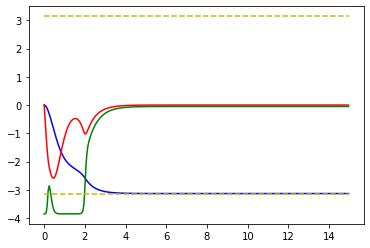

42 tensor(175.3719, grad_fn=<SumBackward0>)


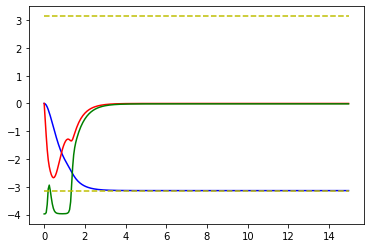

43 tensor(174.0512, grad_fn=<SumBackward0>)


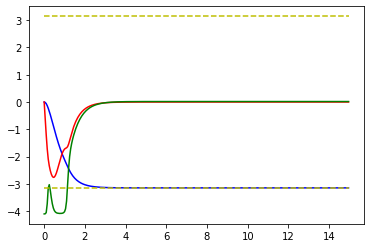

44 tensor(173.9397, grad_fn=<SumBackward0>)


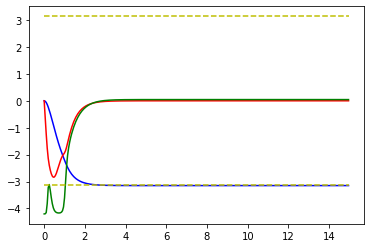

45 tensor(174.1624, grad_fn=<SumBackward0>)


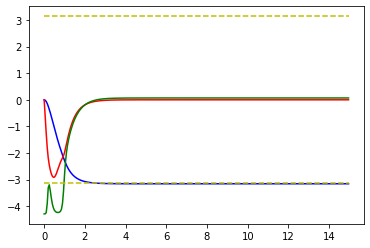

46 tensor(174.3988, grad_fn=<SumBackward0>)


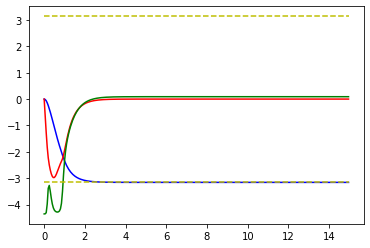

47 tensor(174.5024, grad_fn=<SumBackward0>)


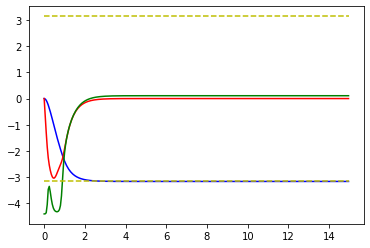

48 tensor(174.4052, grad_fn=<SumBackward0>)


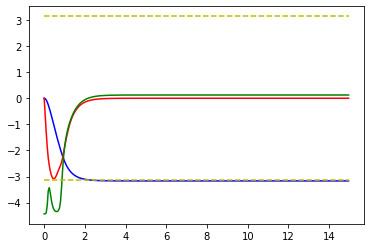

49 tensor(174.0827, grad_fn=<SumBackward0>)


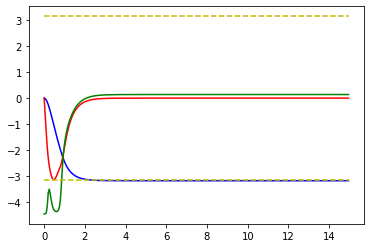

50 tensor(173.5379, grad_fn=<SumBackward0>)


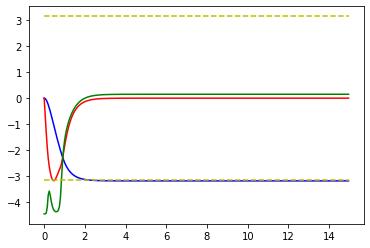

51 tensor(172.7927, grad_fn=<SumBackward0>)


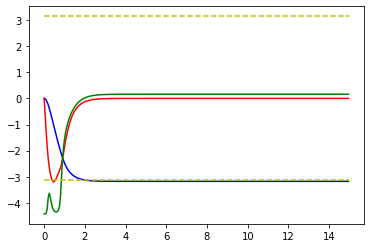

52 tensor(171.8827, grad_fn=<SumBackward0>)


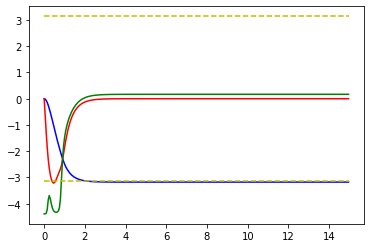

53 tensor(170.8544, grad_fn=<SumBackward0>)


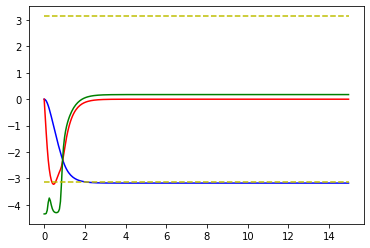

54 tensor(169.7623, grad_fn=<SumBackward0>)


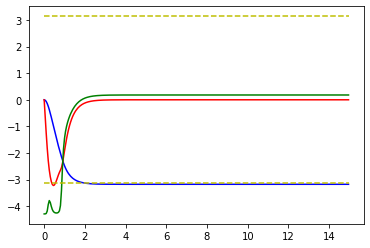

55 tensor(168.6671, grad_fn=<SumBackward0>)


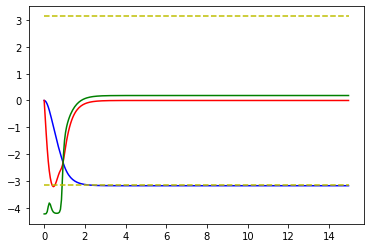

56 tensor(167.6337, grad_fn=<SumBackward0>)


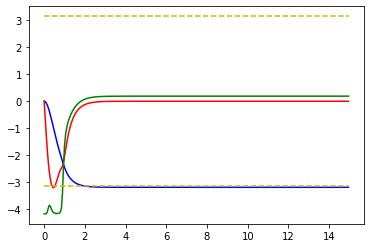

57 tensor(166.7287, grad_fn=<SumBackward0>)


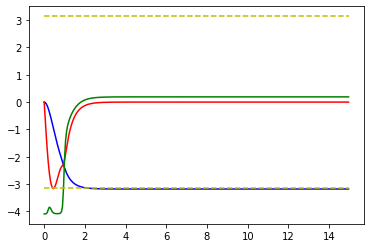

58 tensor(166.0183, grad_fn=<SumBackward0>)


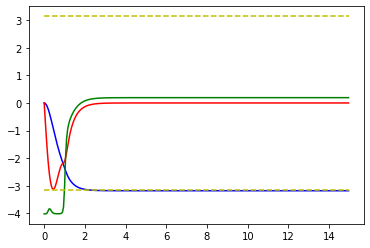

59 tensor(165.5652, grad_fn=<SumBackward0>)


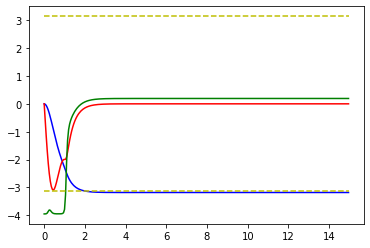

60 tensor(165.4225, grad_fn=<SumBackward0>)


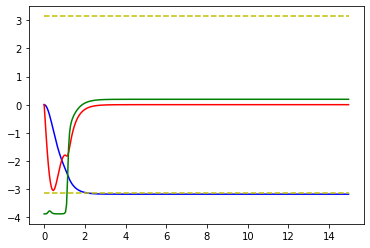

61 tensor(165.6123, grad_fn=<SumBackward0>)


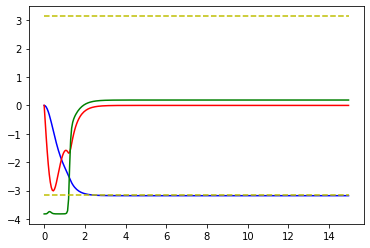

62 tensor(166.0602, grad_fn=<SumBackward0>)


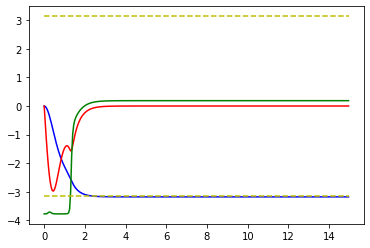

63 tensor(166.4769, grad_fn=<SumBackward0>)


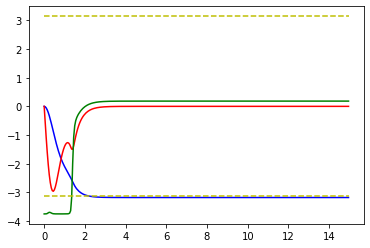

64 tensor(166.4438, grad_fn=<SumBackward0>)


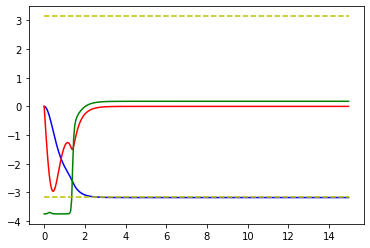

65 tensor(165.9554, grad_fn=<SumBackward0>)


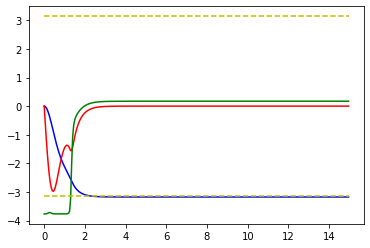

66 tensor(165.3965, grad_fn=<SumBackward0>)


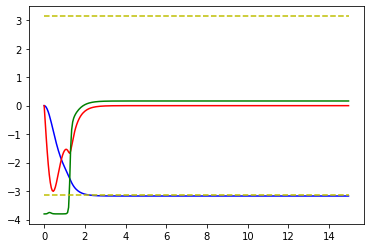

67 tensor(165.0033, grad_fn=<SumBackward0>)


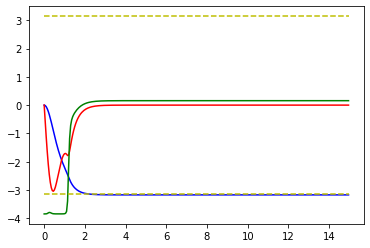

68 tensor(164.8062, grad_fn=<SumBackward0>)


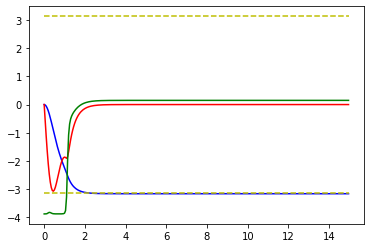

69 tensor(164.7568, grad_fn=<SumBackward0>)


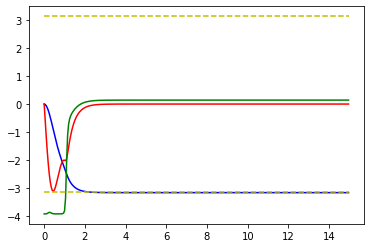

70 tensor(164.7945, grad_fn=<SumBackward0>)


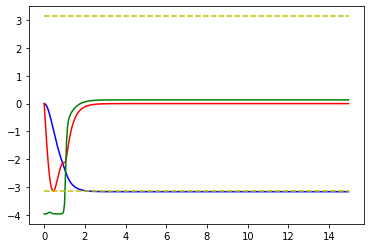

71 tensor(164.8682, grad_fn=<SumBackward0>)


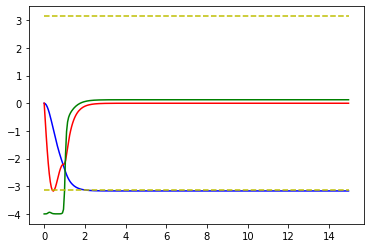

72 tensor(164.9403, grad_fn=<SumBackward0>)


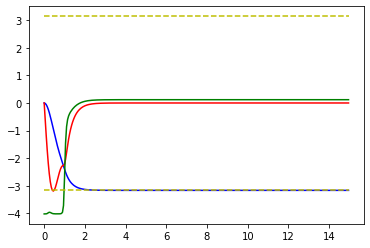

73 tensor(164.9866, grad_fn=<SumBackward0>)


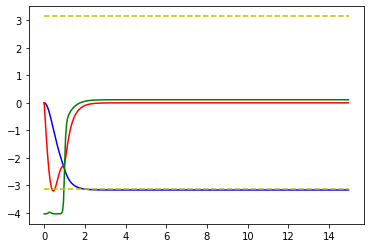

74 tensor(164.9946, grad_fn=<SumBackward0>)


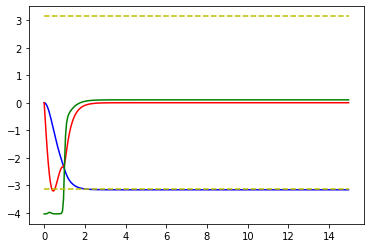

75 tensor(164.9611, grad_fn=<SumBackward0>)


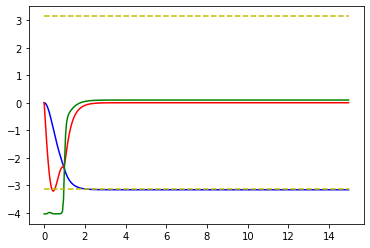

76 tensor(164.8904, grad_fn=<SumBackward0>)


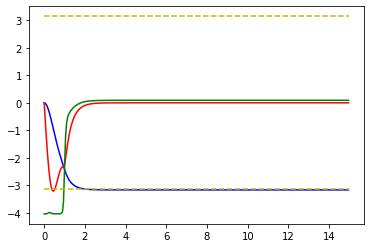

77 tensor(164.7924, grad_fn=<SumBackward0>)


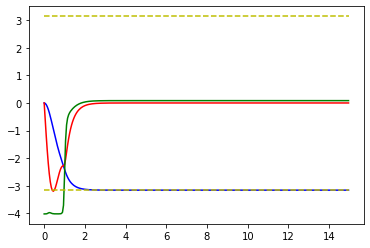

78 tensor(164.6808, grad_fn=<SumBackward0>)


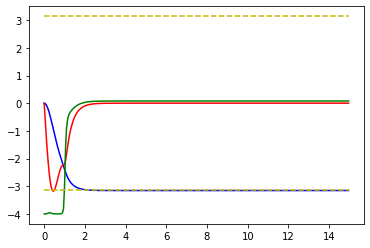

79 tensor(164.5706, grad_fn=<SumBackward0>)


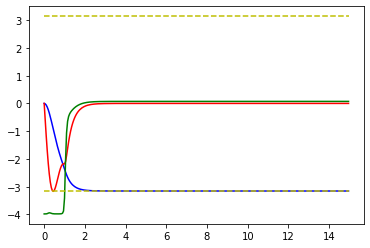

80 tensor(164.4759, grad_fn=<SumBackward0>)


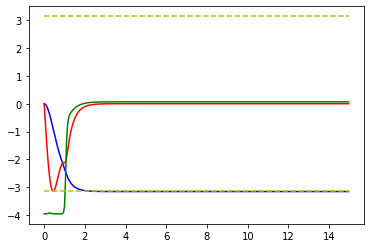

81 tensor(164.4089, grad_fn=<SumBackward0>)


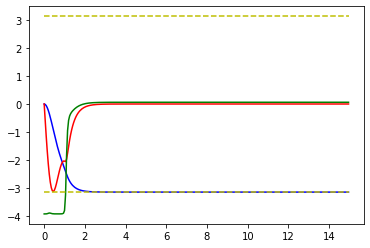

82 tensor(164.3758, grad_fn=<SumBackward0>)


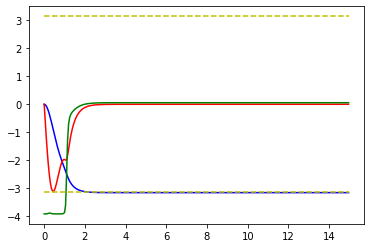

83 tensor(164.3759, grad_fn=<SumBackward0>)


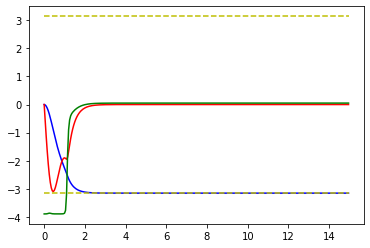

84 tensor(164.3994, grad_fn=<SumBackward0>)


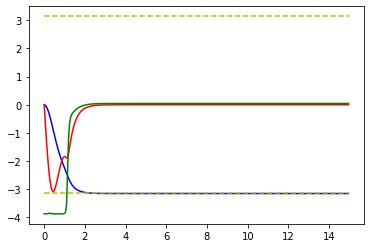

85 tensor(164.4307, grad_fn=<SumBackward0>)


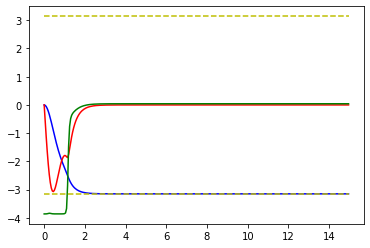

86 tensor(164.4517, grad_fn=<SumBackward0>)


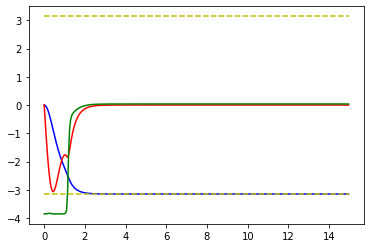

87 tensor(164.4505, grad_fn=<SumBackward0>)


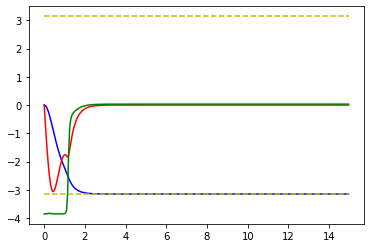

88 tensor(164.4258, grad_fn=<SumBackward0>)


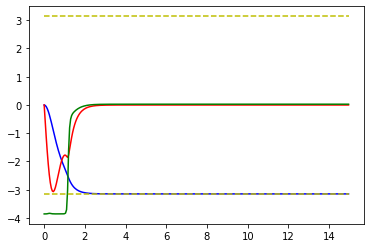

89 tensor(164.3865, grad_fn=<SumBackward0>)


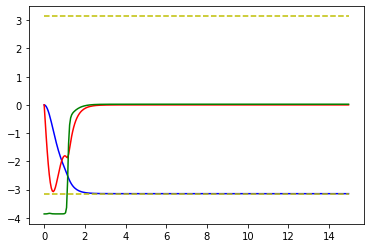

90 tensor(164.3451, grad_fn=<SumBackward0>)


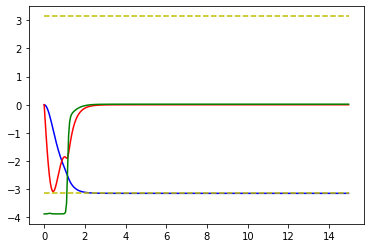

91 tensor(164.3123, grad_fn=<SumBackward0>)


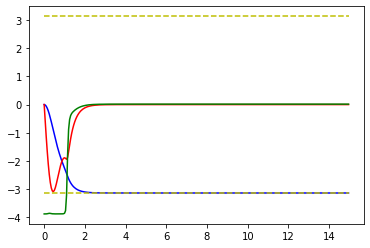

92 tensor(164.2930, grad_fn=<SumBackward0>)


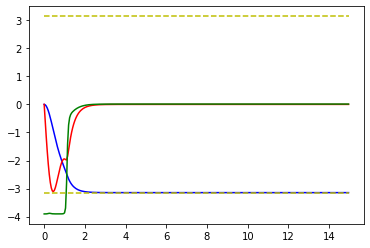

93 tensor(164.2871, grad_fn=<SumBackward0>)


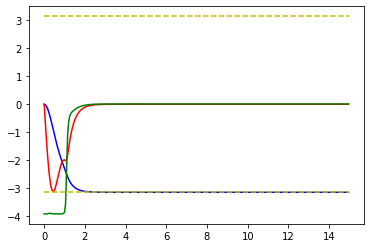

94 tensor(164.2910, grad_fn=<SumBackward0>)


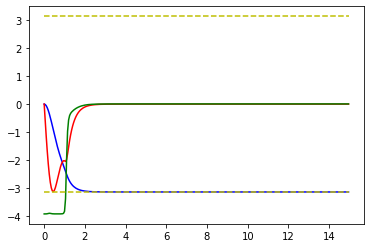

95 tensor(164.2995, grad_fn=<SumBackward0>)


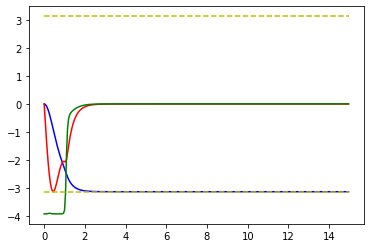

96 tensor(164.3076, grad_fn=<SumBackward0>)


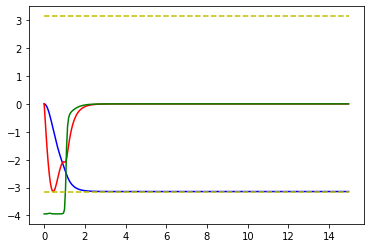

97 tensor(164.3121, grad_fn=<SumBackward0>)


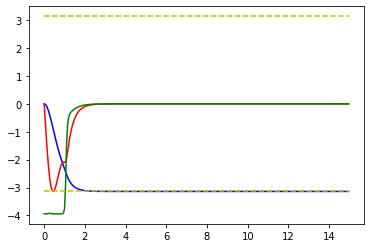

98 tensor(164.3112, grad_fn=<SumBackward0>)


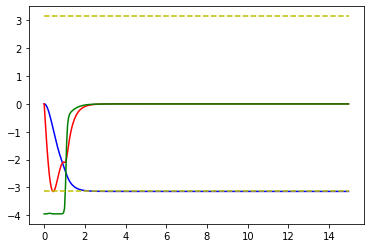

99 tensor(164.3049, grad_fn=<SumBackward0>)


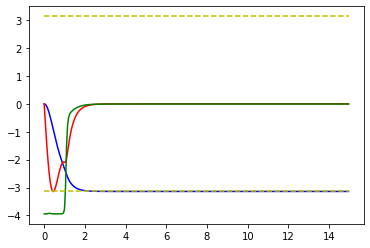

100 tensor(164.2946, grad_fn=<SumBackward0>)


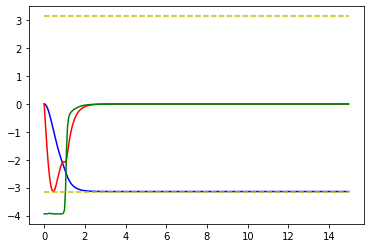

101 tensor(164.2825, grad_fn=<SumBackward0>)


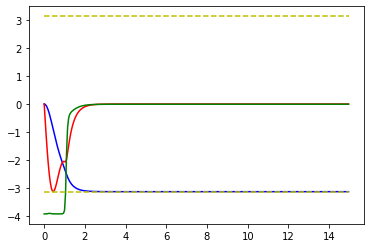

102 tensor(164.2710, grad_fn=<SumBackward0>)


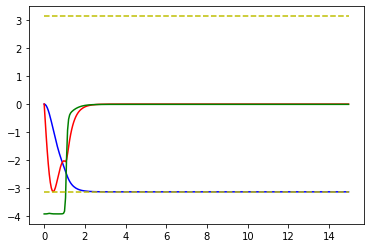

103 tensor(164.2622, grad_fn=<SumBackward0>)


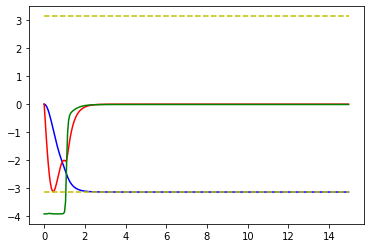

104 tensor(164.2572, grad_fn=<SumBackward0>)


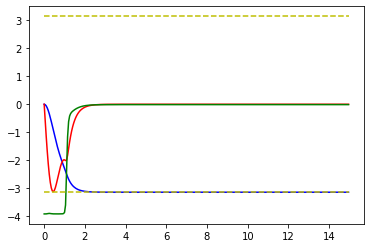

105 tensor(164.2560, grad_fn=<SumBackward0>)


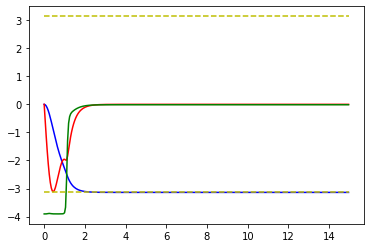

106 tensor(164.2576, grad_fn=<SumBackward0>)


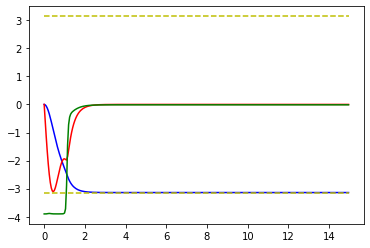

107 tensor(164.2601, grad_fn=<SumBackward0>)


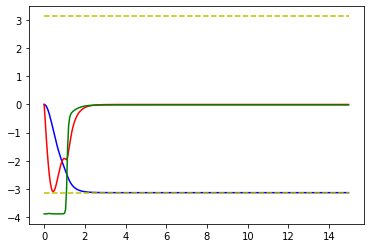

108 tensor(164.2617, grad_fn=<SumBackward0>)


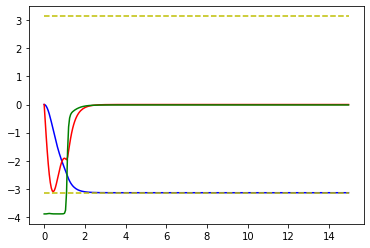

109 tensor(164.2613, grad_fn=<SumBackward0>)


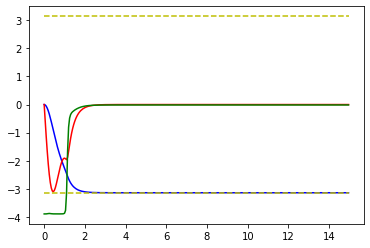

110 tensor(164.2585, grad_fn=<SumBackward0>)


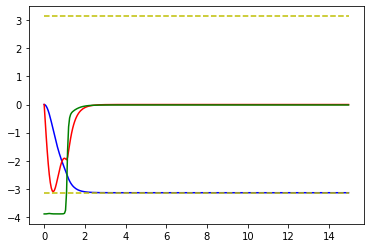

111 tensor(164.2539, grad_fn=<SumBackward0>)


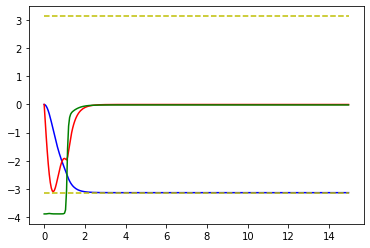

112 tensor(164.2487, grad_fn=<SumBackward0>)


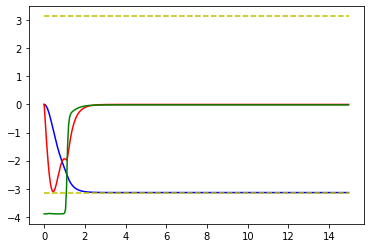

113 tensor(164.2438, grad_fn=<SumBackward0>)


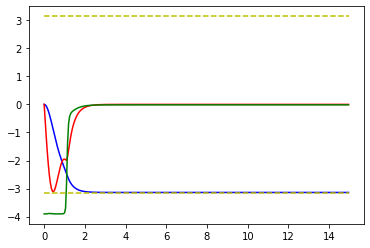

114 tensor(164.2403, grad_fn=<SumBackward0>)


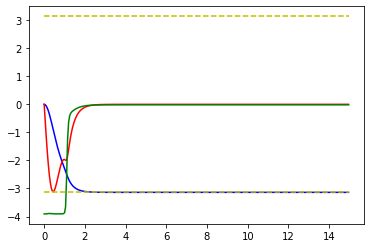

115 tensor(164.2382, grad_fn=<SumBackward0>)


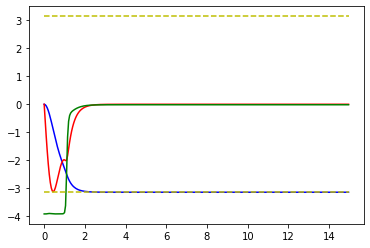

116 tensor(164.2374, grad_fn=<SumBackward0>)


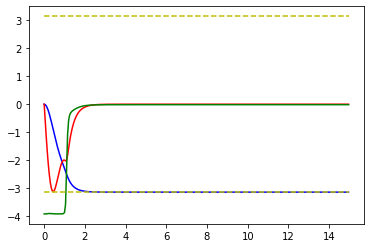

117 tensor(164.2372, grad_fn=<SumBackward0>)


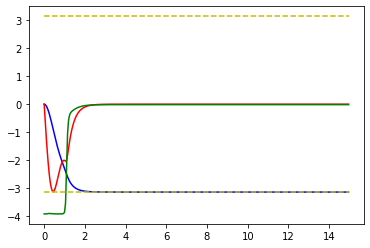

118 tensor(164.2369, grad_fn=<SumBackward0>)


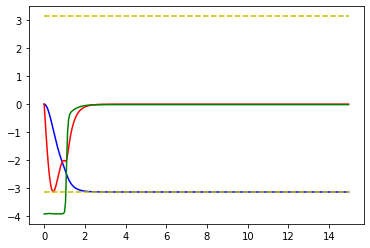

119 tensor(164.2362, grad_fn=<SumBackward0>)


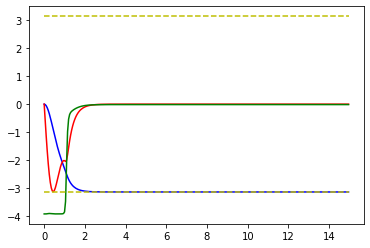

120 tensor(164.2347, grad_fn=<SumBackward0>)


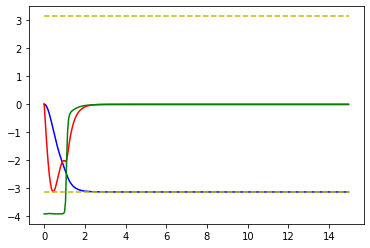

121 tensor(164.2325, grad_fn=<SumBackward0>)


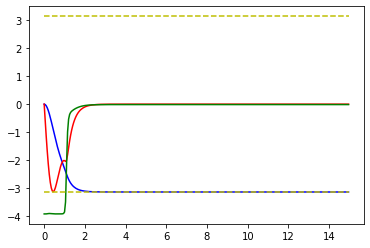

122 tensor(164.2300, grad_fn=<SumBackward0>)


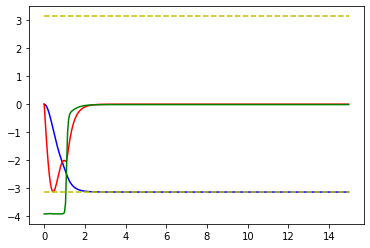

123 tensor(164.2273, grad_fn=<SumBackward0>)


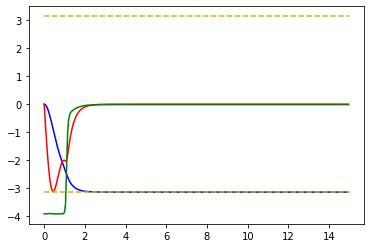

124 tensor(164.2250, grad_fn=<SumBackward0>)


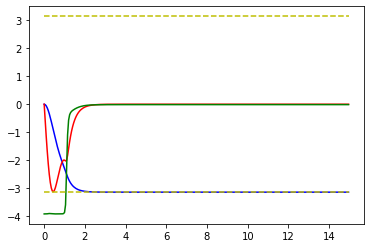

125 tensor(164.2230, grad_fn=<SumBackward0>)


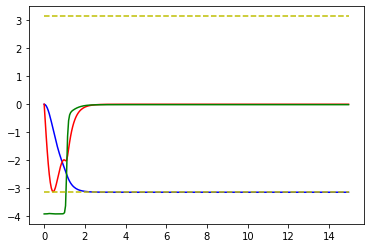

126 tensor(164.2215, grad_fn=<SumBackward0>)


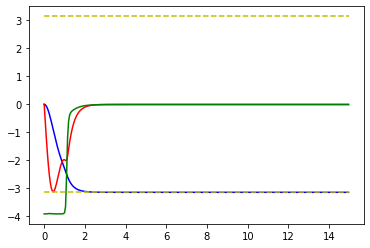

127 tensor(164.2205, grad_fn=<SumBackward0>)


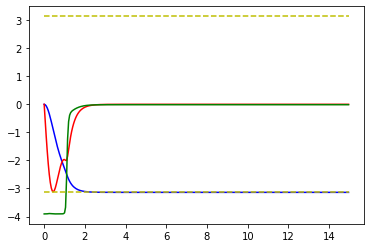

128 tensor(164.2196, grad_fn=<SumBackward0>)


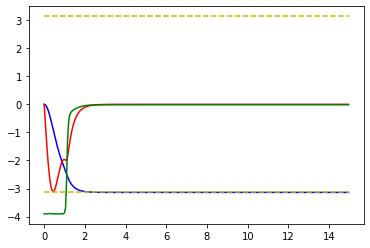

129 tensor(164.2186, grad_fn=<SumBackward0>)


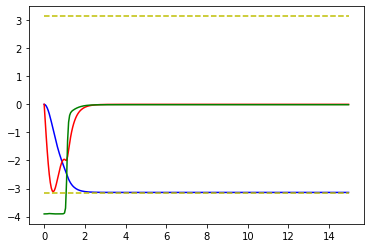

130 tensor(164.2174, grad_fn=<SumBackward0>)


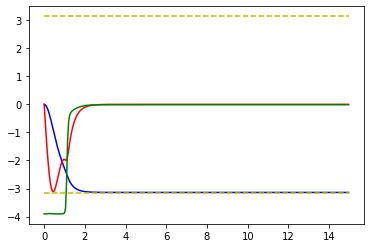

131 tensor(164.2160, grad_fn=<SumBackward0>)


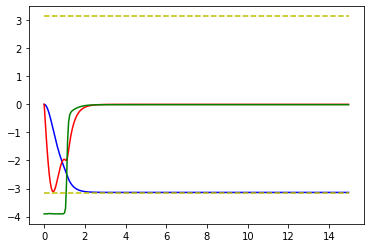

132 tensor(164.2143, grad_fn=<SumBackward0>)


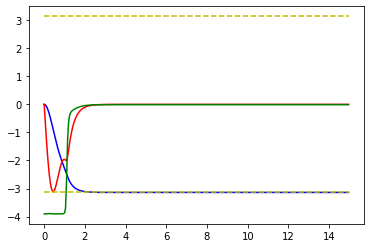

133 tensor(164.2126, grad_fn=<SumBackward0>)


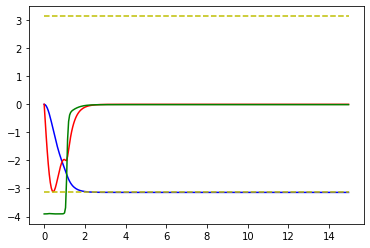

134 tensor(164.2109, grad_fn=<SumBackward0>)


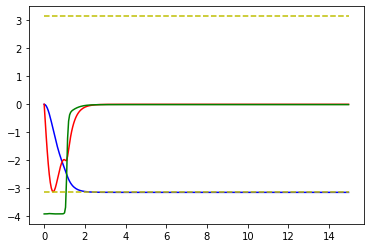

135 tensor(164.2094, grad_fn=<SumBackward0>)


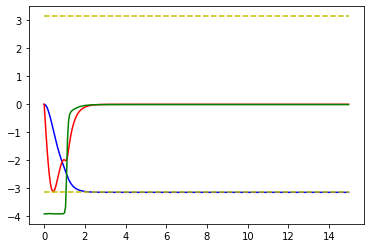

136 tensor(164.2081, grad_fn=<SumBackward0>)


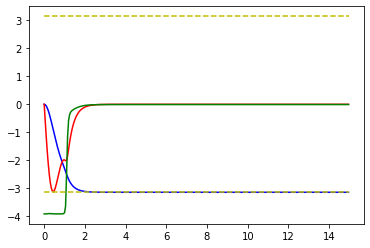

137 tensor(164.2069, grad_fn=<SumBackward0>)


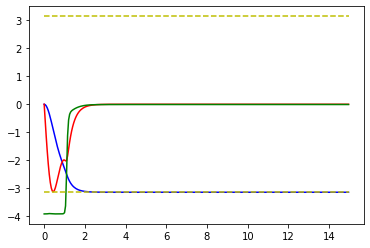

138 tensor(164.2058, grad_fn=<SumBackward0>)


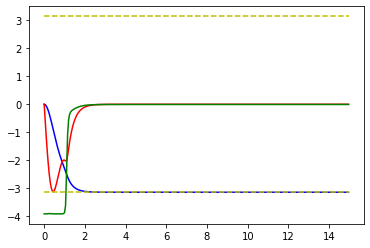

139 tensor(164.2048, grad_fn=<SumBackward0>)


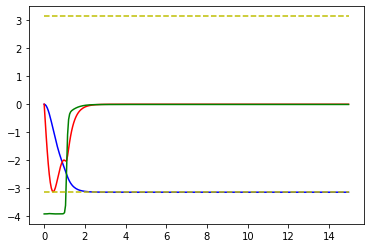

140 tensor(164.2038, grad_fn=<SumBackward0>)


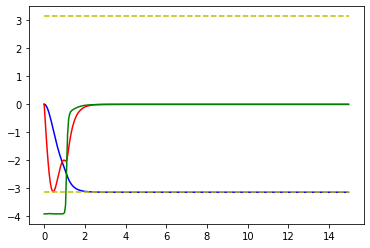

141 tensor(164.2026, grad_fn=<SumBackward0>)


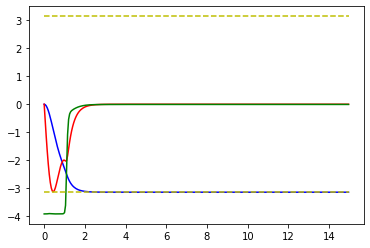

142 tensor(164.2014, grad_fn=<SumBackward0>)


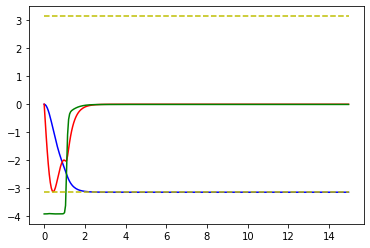

143 tensor(164.2002, grad_fn=<SumBackward0>)


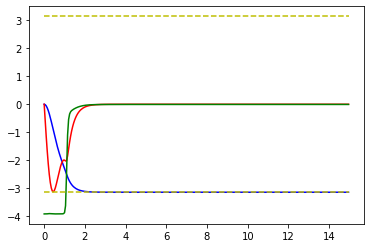

144 tensor(164.1990, grad_fn=<SumBackward0>)


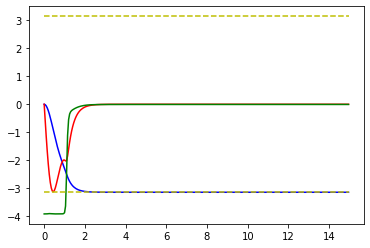

145 tensor(164.1978, grad_fn=<SumBackward0>)


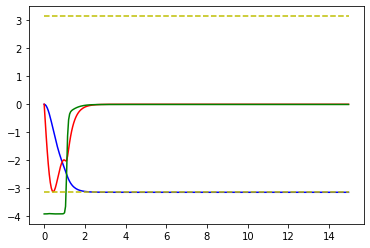

146 tensor(164.1967, grad_fn=<SumBackward0>)


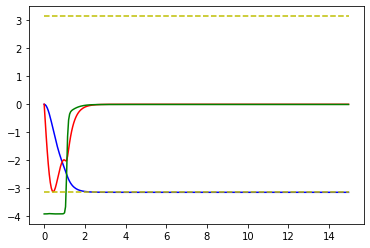

147 tensor(164.1957, grad_fn=<SumBackward0>)


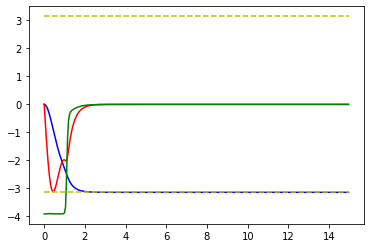

148 tensor(164.1947, grad_fn=<SumBackward0>)


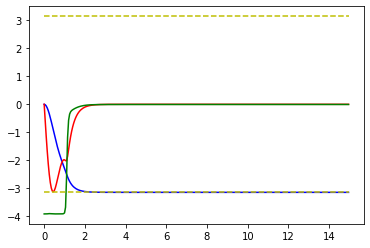

149 tensor(164.1937, grad_fn=<SumBackward0>)


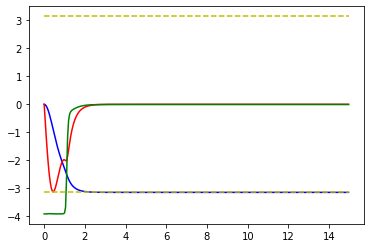

150 tensor(164.1927, grad_fn=<SumBackward0>)


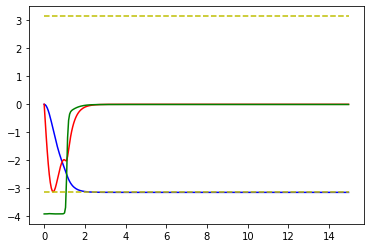

151 tensor(164.1917, grad_fn=<SumBackward0>)


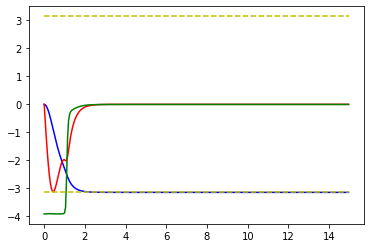

152 tensor(164.1906, grad_fn=<SumBackward0>)


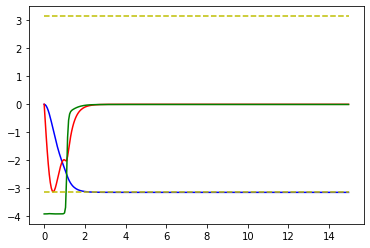

153 tensor(164.1895, grad_fn=<SumBackward0>)


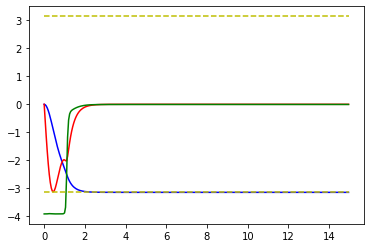

154 tensor(164.1884, grad_fn=<SumBackward0>)


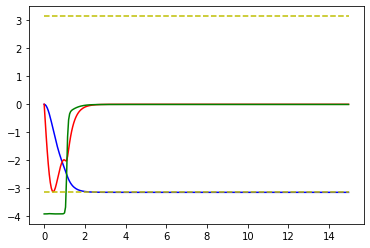

155 tensor(164.1874, grad_fn=<SumBackward0>)


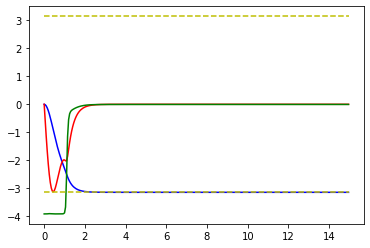

156 tensor(164.1864, grad_fn=<SumBackward0>)


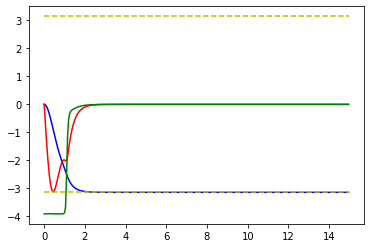

157 tensor(164.1854, grad_fn=<SumBackward0>)


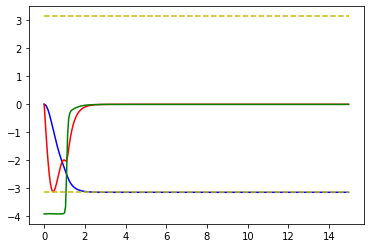

158 tensor(164.1844, grad_fn=<SumBackward0>)


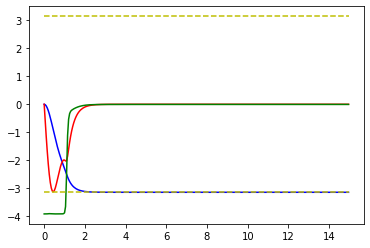

159 tensor(164.1834, grad_fn=<SumBackward0>)


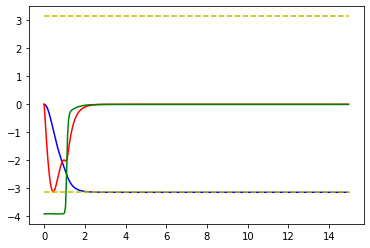

160 tensor(164.1824, grad_fn=<SumBackward0>)


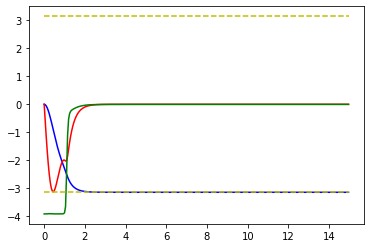

161 tensor(164.1814, grad_fn=<SumBackward0>)


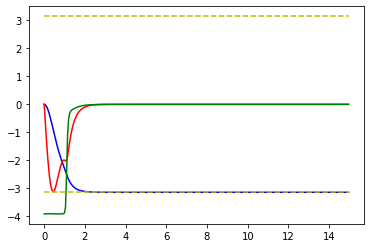

162 tensor(164.1804, grad_fn=<SumBackward0>)


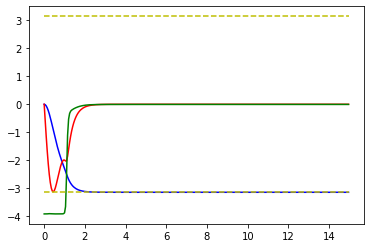

163 tensor(164.1793, grad_fn=<SumBackward0>)


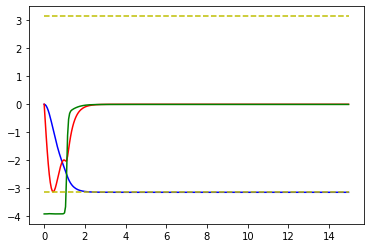

164 tensor(164.1783, grad_fn=<SumBackward0>)


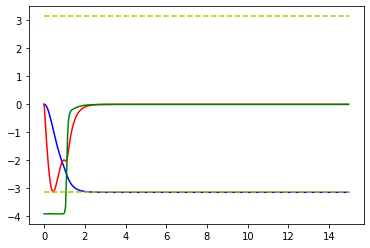

165 tensor(164.1773, grad_fn=<SumBackward0>)


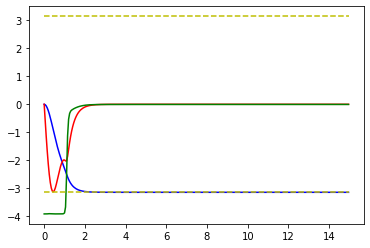

166 tensor(164.1763, grad_fn=<SumBackward0>)


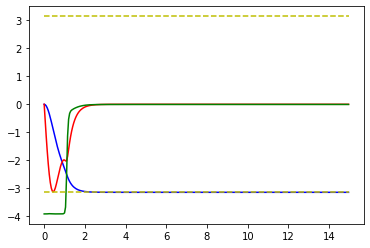

167 tensor(164.1753, grad_fn=<SumBackward0>)


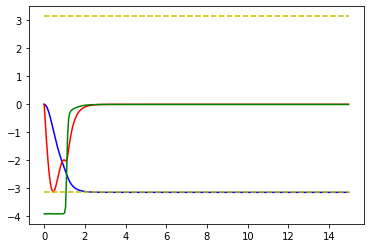

168 tensor(164.1743, grad_fn=<SumBackward0>)


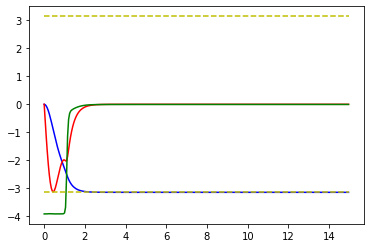

169 tensor(164.1732, grad_fn=<SumBackward0>)


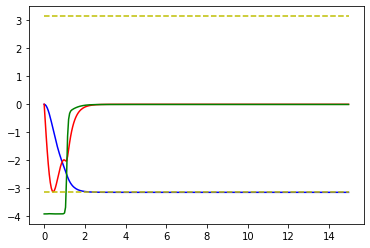

170 tensor(164.1722, grad_fn=<SumBackward0>)


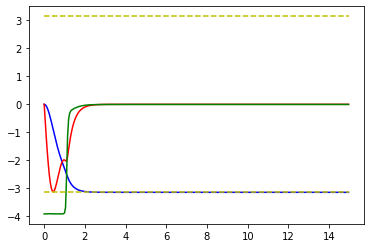

171 tensor(164.1712, grad_fn=<SumBackward0>)


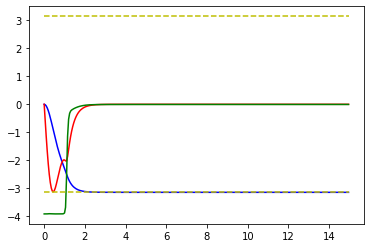

172 tensor(164.1702, grad_fn=<SumBackward0>)


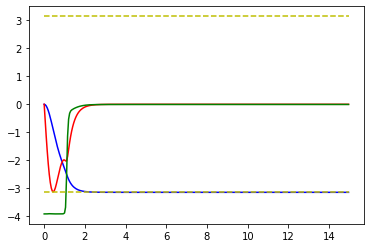

173 tensor(164.1692, grad_fn=<SumBackward0>)


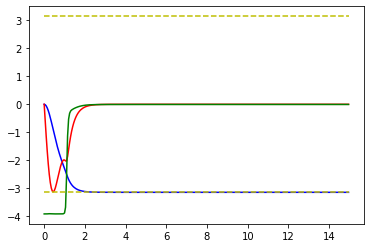

174 tensor(164.1681, grad_fn=<SumBackward0>)


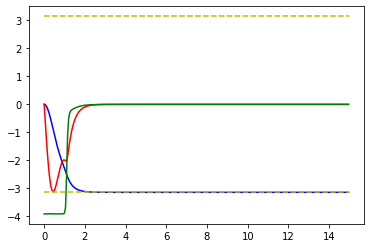

175 tensor(164.1670, grad_fn=<SumBackward0>)


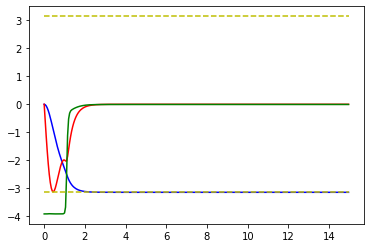

176 tensor(164.1660, grad_fn=<SumBackward0>)


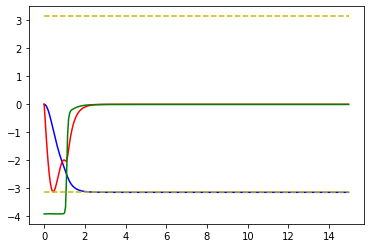

177 tensor(164.1649, grad_fn=<SumBackward0>)


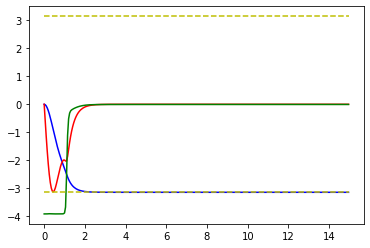

178 tensor(164.1639, grad_fn=<SumBackward0>)


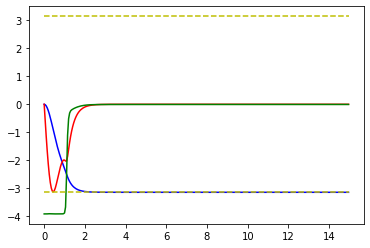

179 tensor(164.1630, grad_fn=<SumBackward0>)


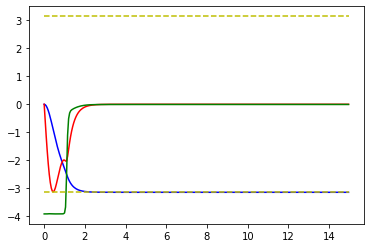

180 tensor(164.1623, grad_fn=<SumBackward0>)


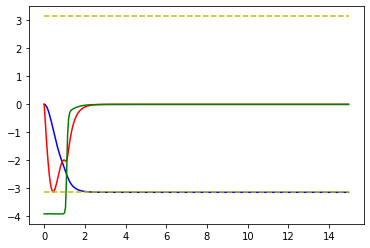

181 tensor(164.1617, grad_fn=<SumBackward0>)


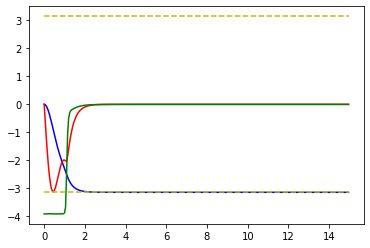

182 tensor(164.1610, grad_fn=<SumBackward0>)


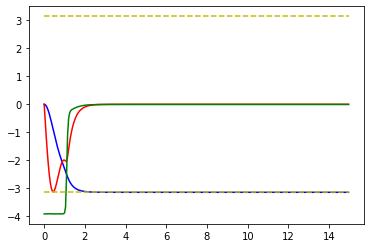

183 tensor(164.1603, grad_fn=<SumBackward0>)


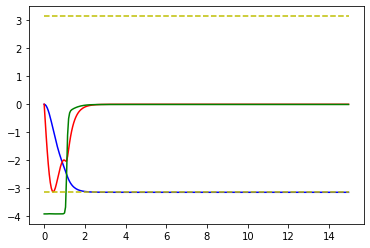

184 tensor(164.1597, grad_fn=<SumBackward0>)


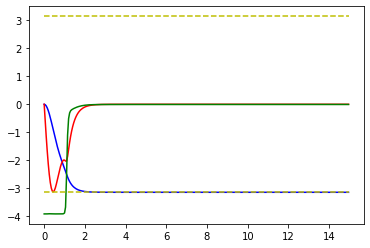

185 tensor(164.1591, grad_fn=<SumBackward0>)


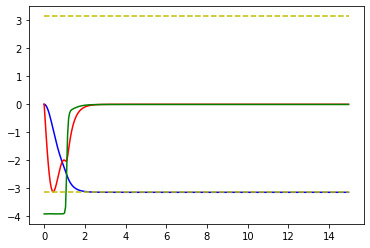

186 tensor(164.1585, grad_fn=<SumBackward0>)


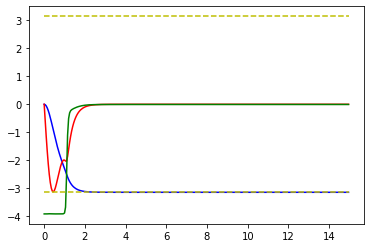

187 tensor(164.1579, grad_fn=<SumBackward0>)


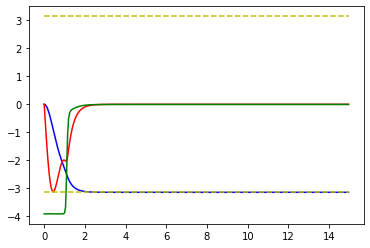

188 tensor(164.1572, grad_fn=<SumBackward0>)


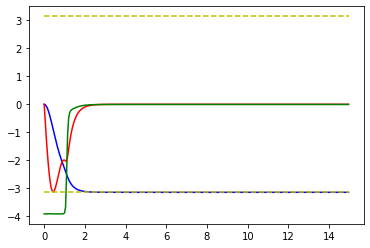

189 tensor(164.1567, grad_fn=<SumBackward0>)


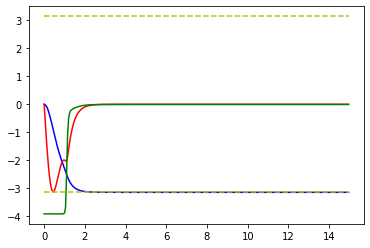

190 tensor(164.1561, grad_fn=<SumBackward0>)


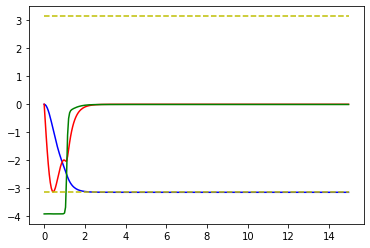

191 tensor(164.1555, grad_fn=<SumBackward0>)


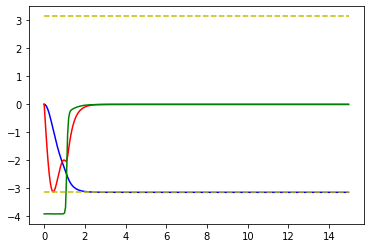

192 tensor(164.1549, grad_fn=<SumBackward0>)


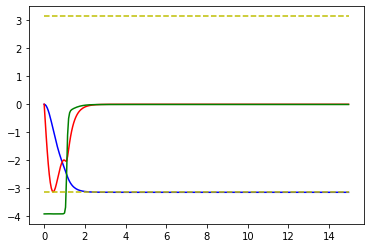

193 tensor(164.1543, grad_fn=<SumBackward0>)


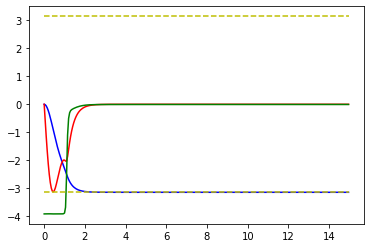

194 tensor(164.1538, grad_fn=<SumBackward0>)


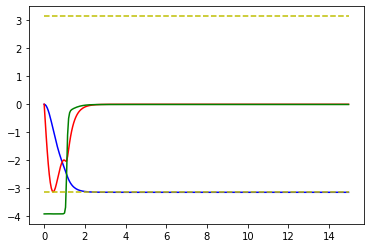

195 tensor(164.1532, grad_fn=<SumBackward0>)


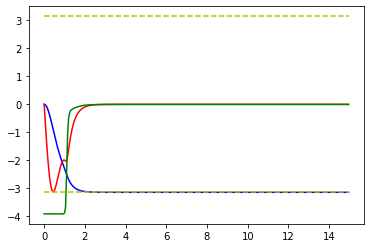

196 tensor(164.1526, grad_fn=<SumBackward0>)


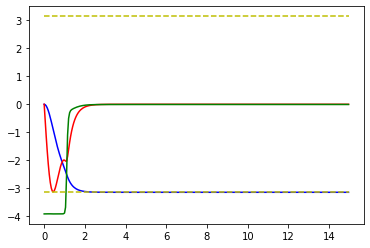

197 tensor(164.1520, grad_fn=<SumBackward0>)


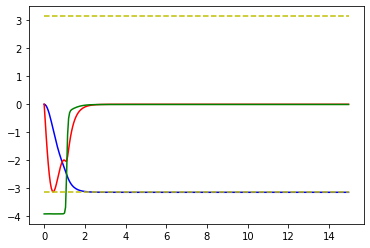

198 tensor(164.1514, grad_fn=<SumBackward0>)


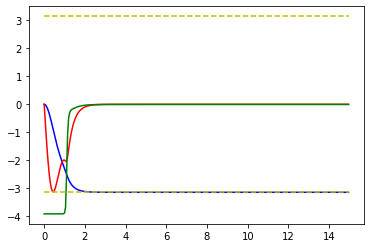

199 tensor(164.1509, grad_fn=<SumBackward0>)


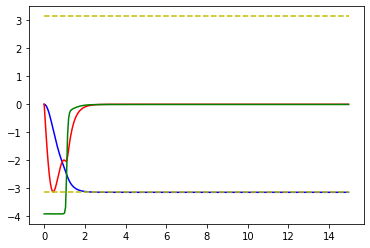

200 tensor(164.1503, grad_fn=<SumBackward0>)


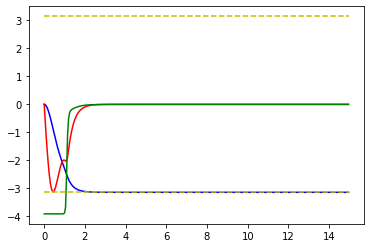

201 tensor(164.1497, grad_fn=<SumBackward0>)


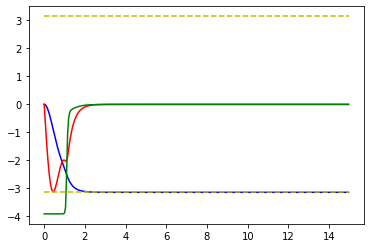

202 tensor(164.1492, grad_fn=<SumBackward0>)


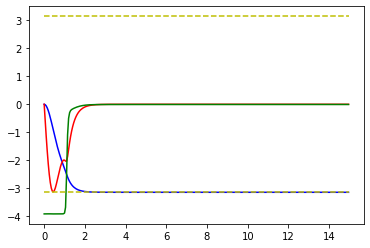

203 tensor(164.1486, grad_fn=<SumBackward0>)


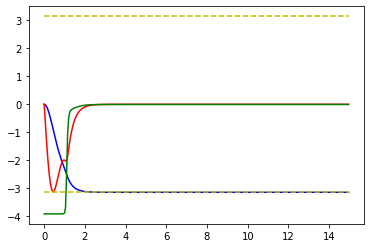

204 tensor(164.1480, grad_fn=<SumBackward0>)


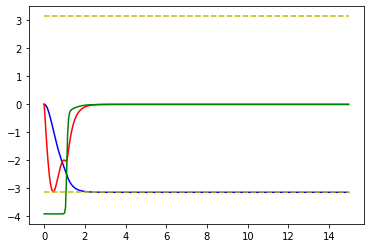

205 tensor(164.1474, grad_fn=<SumBackward0>)


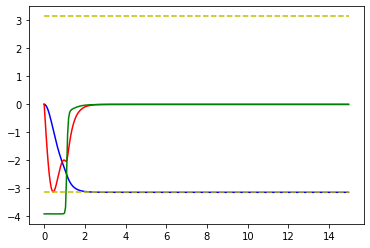

206 tensor(164.1468, grad_fn=<SumBackward0>)


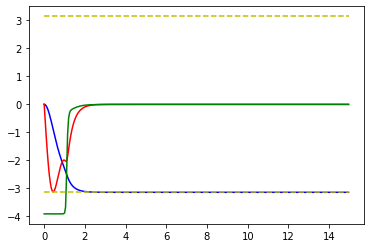

207 tensor(164.1462, grad_fn=<SumBackward0>)


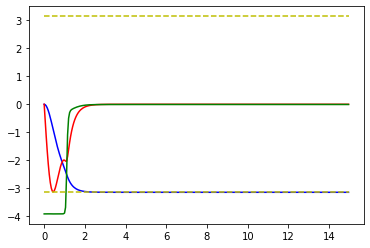

KeyboardInterrupt: 

In [11]:
init_state = torch.tensor([0, 0]).reshape(1, -1).float()
dt = 0.05
steps = 300
num_epoch = 10000

target = torch.cat([torch.ones(steps, 1) * np.pi, torch.ones(steps, 1) * -np.pi], dim=1)

for epoch in range(num_epoch):
    optimizer.zero_grad()
    
    # Generate Trajectory
    # init_states = torch.cat([(torch.rand(127, 2) - 0.5) * 4, init_state], dim=0)
    init_states = init_state
    t_span = torch.linspace(0, dt * (steps-1), steps)
    traj = pendulumODE.trajectory(init_states, t_span)
    dummy = torch.stack([torch.cos(traj[:, :, 0]), torch.sin(traj[:, :, 0]), traj[:, :, 1]], dim=2).reshape(-1, 3)
    actions = pendulumODE.defunc.m.policy(dummy).reshape(steps, 1, 1)
    # actions = pendulumODE.defunc.m.policy(traj).reshape(steps, 1, 1)
    
    loss = total_cost(traj, actions)
    loss.backward()
    optimizer.step()
    
#     def closure():
#         optimizer.zero_grad()
#         init_states = init_state
#         t_span = torch.linspace(0, dt * (steps-1), steps)
#         traj = pendulumODE.trajectory(init_states, t_span)
#         dummy = torch.stack([torch.cos(traj[:, :, 0]), torch.sin(traj[:, :, 0]), traj[:, :, 1]], dim=2).reshape(-1, 3)
#         actions = pendulumODE.defunc.m.policy(dummy).reshape(steps, 1, 1)
#         loss = total_cost(traj, actions)
#         loss.backward()
#         return loss

#     optimizer.step(closure)

    # print statistics
    if epoch % 1 == 0:
        print(epoch, loss)
        plt.plot(t_span.detach().numpy(), traj[:, -1, 0].detach().numpy(), 'b-')
        plt.plot(t_span.detach().numpy(), traj[:, -1, 1].detach().numpy(), 'r-')
        plt.plot(t_span.detach().numpy(), actions[:, -1, :].detach().numpy(), 'g-')
        plt.plot(t_span.detach().numpy(), target, 'y--')
        # plt.ylim(-4, 4)
        plt.show()
print('Finished Training')

In [ ]:
pendulumODE.eval()
None

In [ ]:
init_state = torch.tensor([0, 0]).reshape(1, -1).float()
t_span = torch.linspace(0, 5, 100)
traj = pendulumODE.trajectory(init_state, t_span)
# dummy = torch.stack([torch.cos(traj[:, 0, 0]), torch.sin(traj[:, 0, 0]), traj[:, 0, 1]], dim=1)
# actions = pendulumODE.defunc.m.policy(dummy)
actions = pendulumODE.defunc.m.policy(traj)
print(traj.shape)
print(actions.shape)

In [ ]:
plt.plot(t_span.detach().numpy(), traj[:, 0, 0:2].detach().numpy())
plt.plot(t_span.detach().numpy(), actions.detach().numpy())

## Conclusion